## GWO & Hail Environment Relationship
##### Dr. Victor Gensini (Fall 2017)
##### Department of Geographic and Atmospheric Sciences
<img style="float:left;height:40px"src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQthtdrc2lZyEOC1iiwubFyvNfzJE7q7_GCTdlFF3peKckmi7cN">

In [1]:
import Ngl, datetime, os, calendar
import numpy as np
import pandas as pd
from netCDF4 import date2num,date2index
from netCDF4 import Dataset
from IPython.display import Image
import scipy.ndimage

### GWO data

In [2]:
nc1 = Dataset('narr_latlon.nc','r',format='NETCDF4_CLASSIC')
lats = nc1.variables["lats"][0][:][:]
lons = nc1.variables["lons"][0][:][:]
nc1.close()
phase_st_anoms = np.empty((0,277,349))
probs_scp = np.empty((0,277,349))
nc = Dataset('scp_cin_1979_2016.nc','r',format='NETCDF4_CLASSIC')
mean_scp_daily = np.load('narr_mean_scp1prob_daily.npy')

In [3]:
gwo_file = 'gwo.csv'
gwo_df = pd.read_csv(gwo_file)
formats = '%Y-%m-%d'
gwo_df['date']=pd.to_datetime(gwo_df['date'], format=formats)
gwo_df=gwo_df.set_index(pd.DatetimeIndex(gwo_df['date']))
hail_file = '1955-2016_hail.csv'
hail_df = pd.read_csv(hail_file)
formats1 = '%m/%d/%Y'
hail_df['datei']=pd.to_datetime(hail_df['date'], format=formats1)
hail_df=hail_df.set_index(pd.DatetimeIndex(hail_df['datei']))
sevhail_df = hail_df[hail_df.mag>=1]
sighail_df = hail_df[hail_df.mag>=2]
gianthail_df = hail_df[hail_df.mag>=4]
amp=1
phases=[1.5,2.5,3.5,4.5,5.5,6.5,7.5,0.5]
months=np.arange(1,13,1)
months=[9]
phasetxt=[1,2,3,4,5,6,7,8]
phaseltr=['a)','b)','c)','d)','e)','f)','g)','h)']

In [4]:
for month in months:
    for i,phase in enumerate(phases):
        query='amp>=%s & phase==%s & year>=1979 & year<=2016 & month==%s' % (amp,phase,month)
        phase_amp_df = gwo_df.query(query)      
        #query='hr>=13 & hr<=18'
        #query='hr>=16 & hr<=16'
        #sighail_df=sighail_df.query(query)
        sig_hail_df=sighail_df.loc[sighail_df['datei'].isin(phase_amp_df['date'])]
        hail_lats = sig_hail_df['slat']
        hail_lons = sig_hail_df['slon']
        for dt in phase_amp_df['date']+datetime.timedelta(hours=21):
            if calendar.isleap(dt.year)==True:
                tt=dt.timetuple().tm_yday-2
            else:
                tt=dt.timetuple().tm_yday-1
            day_mean_scp=mean_scp_daily[tt][:][:]
            #day_mean_scp_log=mean_scp_daily_log[tt][:][:]
            #day_stdev_scp=stdev_scp_daily[tt][:][:]
            #day_stdev_scp_log=stdev_scp_daily_log[tt][:][:] 
            idex = date2index(dt,nc['time'])
            scp = nc.variables["scp"][idex][:][:]
            cin  = nc.variables["sbcin"][idex][:][:]
            #cin mask
            term5 = np.fabs(cin)
            term5[np.fabs(cin)>50]=0.
            term5[np.fabs(cin)<=50]=1.
            scp = scp * term5
            scp[scp<1]=0.
            scp[scp>=1]=1.
            #anom = scp-day_mean_scp
            #st_anom = anom/day_stdev_scp
            phase_st_anoms = np.append(phase_st_anoms,[scp],axis=0)
            probs_scp = np.append(probs_scp,[day_mean_scp],axis=0)
        mean_ph1 = np.mean(phase_st_anoms,axis=0)
        mean_probs = np.mean(probs_scp,axis=0)
        prob_anom = mean_ph1-mean_probs
        #mean_ph1 = np.mean(phase_st_anoms,axis=0)
        #Guassian smooth probs
        phase_st_anoms = np.empty((0,277,349))
        probs_scp = np.empty((0,277,349))
        sigma = 1
        mean_ph1 = scipy.ndimage.filters.gaussian_filter(prob_anom,sigma,order=0)
        wkres           =  Ngl.Resources()                      #-- generate an resources object for workstation
        wkres.wkWidth   =  1500                                 #-- plot resolution 2500 pixel width
        wkres.wkHeight  =  1000                                 #-- plot resolution 2000 pixel height
        wks_type        = "png"                                 #-- graphics output type
        wks             =  Ngl.open_wks(wks_type,str(month)+'_'+str(phasetxt[i]),wkres)  #-- Open the Ngl canvas for drawing
        res                        =  Ngl.Resources()
        res.nglFrame=False
        res.mpFillOn               = True                     # map fill on
        res.mpOutlineOn            = True                     # map outline on
        res.mpLandFillColor        = "transparent"            # fill land transparent
        res.mpOceanFillColor       = "grey"                   # fill ocean grey
        res.mpInlandWaterFillColor = "grey"                   # fill inland water grey
        res.mpFillDrawOrder        = "PostDraw"               # draw mapfill after contour plot
        res.mpGridAndLimbOn        = True                     # turn on gridlines
        res.mpProjection           = "LambertConformal"       # set map projection
        res.cnLevelSelectionMode   = "ManualLevels"           # set manual contour levels
        res.cnMinLevelValF         = -.1                    # set contour min value
        res.cnMaxLevelValF         = .1                  # set contour max value
        res.cnLevelSpacingF        = .01                       # set contour interval
        res.cnFillOn               = True                     # turn on contour fill
        res.cnLinesOn              = False                    # turn off contour lines
        res.cnLineLabelsOn         = False                    # turn off line labels
        res.cnFillMode             = "RasterFill"             # These two resources
        res.trGridType             = "TriangularMesh"         # can speed up plotting.
        res.cnFillPalette          = "nrl_sirkes"     # pick a colorbar
        res.mpOutlineBoundarySets  = "GeophysicalAndUSStates" # pick map outline boundaries
        res.mpLimitMode            = "Corners"                #-- select a sub-region
        res.mpLeftCornerLonF       =  -120                    #-- left longitude value
        res.mpRightCornerLonF      =  -60                     #-- right longitude value
        res.mpLeftCornerLatF       =  20                      #-- left latitude value
        res.mpRightCornerLatF      =  50                      #-- right latitude value
        res.lbLabelBarOn = False
        res.lbOrientation          = "horizontal"             # colorbar label orientation; default is vertical
        res.lbBoxMinorExtentF      = 0.12
        res.lbBoxEndCapStyle = "TriangleBothEnds"
        res.sfXArray               = lons                     # set array of x values from netCDF longitudes
        res.sfYArray               = lats                     # set array of y valyes from netCDF latitudes
        #res.tiMainString           = "April Phase 1 & Sig Hail (1979-2016)"  # Make a plot title
        res.tiMainFontHeightF      = 0.015                    # set plot font title size
        res.mpLambertParallel1F    = 33                       # set lambert 1st parallel
        res.mpLambertParallel2F    = 45                       # set lambert 2nd parallel
        res.mpLambertMeridianF     = -95                      # set lambert centering longitude
        plot = Ngl.contour_map(wks,mean_ph1,res)               # make a countour map
        poly_res=Ngl.Resources()
        poly_res.gsMarkerIndex=1
        poly_res.gsMarkerSizeF=0.022
        Ngl.add_polymarker(wks,plot,hail_lons,hail_lats,poly_res)
        txres               = Ngl.Resources()
        txres.txAngleF              = 0.
        txres.txJust                = "TopLeft"
        #txres.txPerimOn             = True
        txres.txFontColor           = "black"
        #txres.txBackgroundFillColor = "gray75"
        Ngl.text_ndc(wks,phaseltr[i],.04,.84,txres)
        Ngl.draw(plot)
        Ngl.frame(wks)

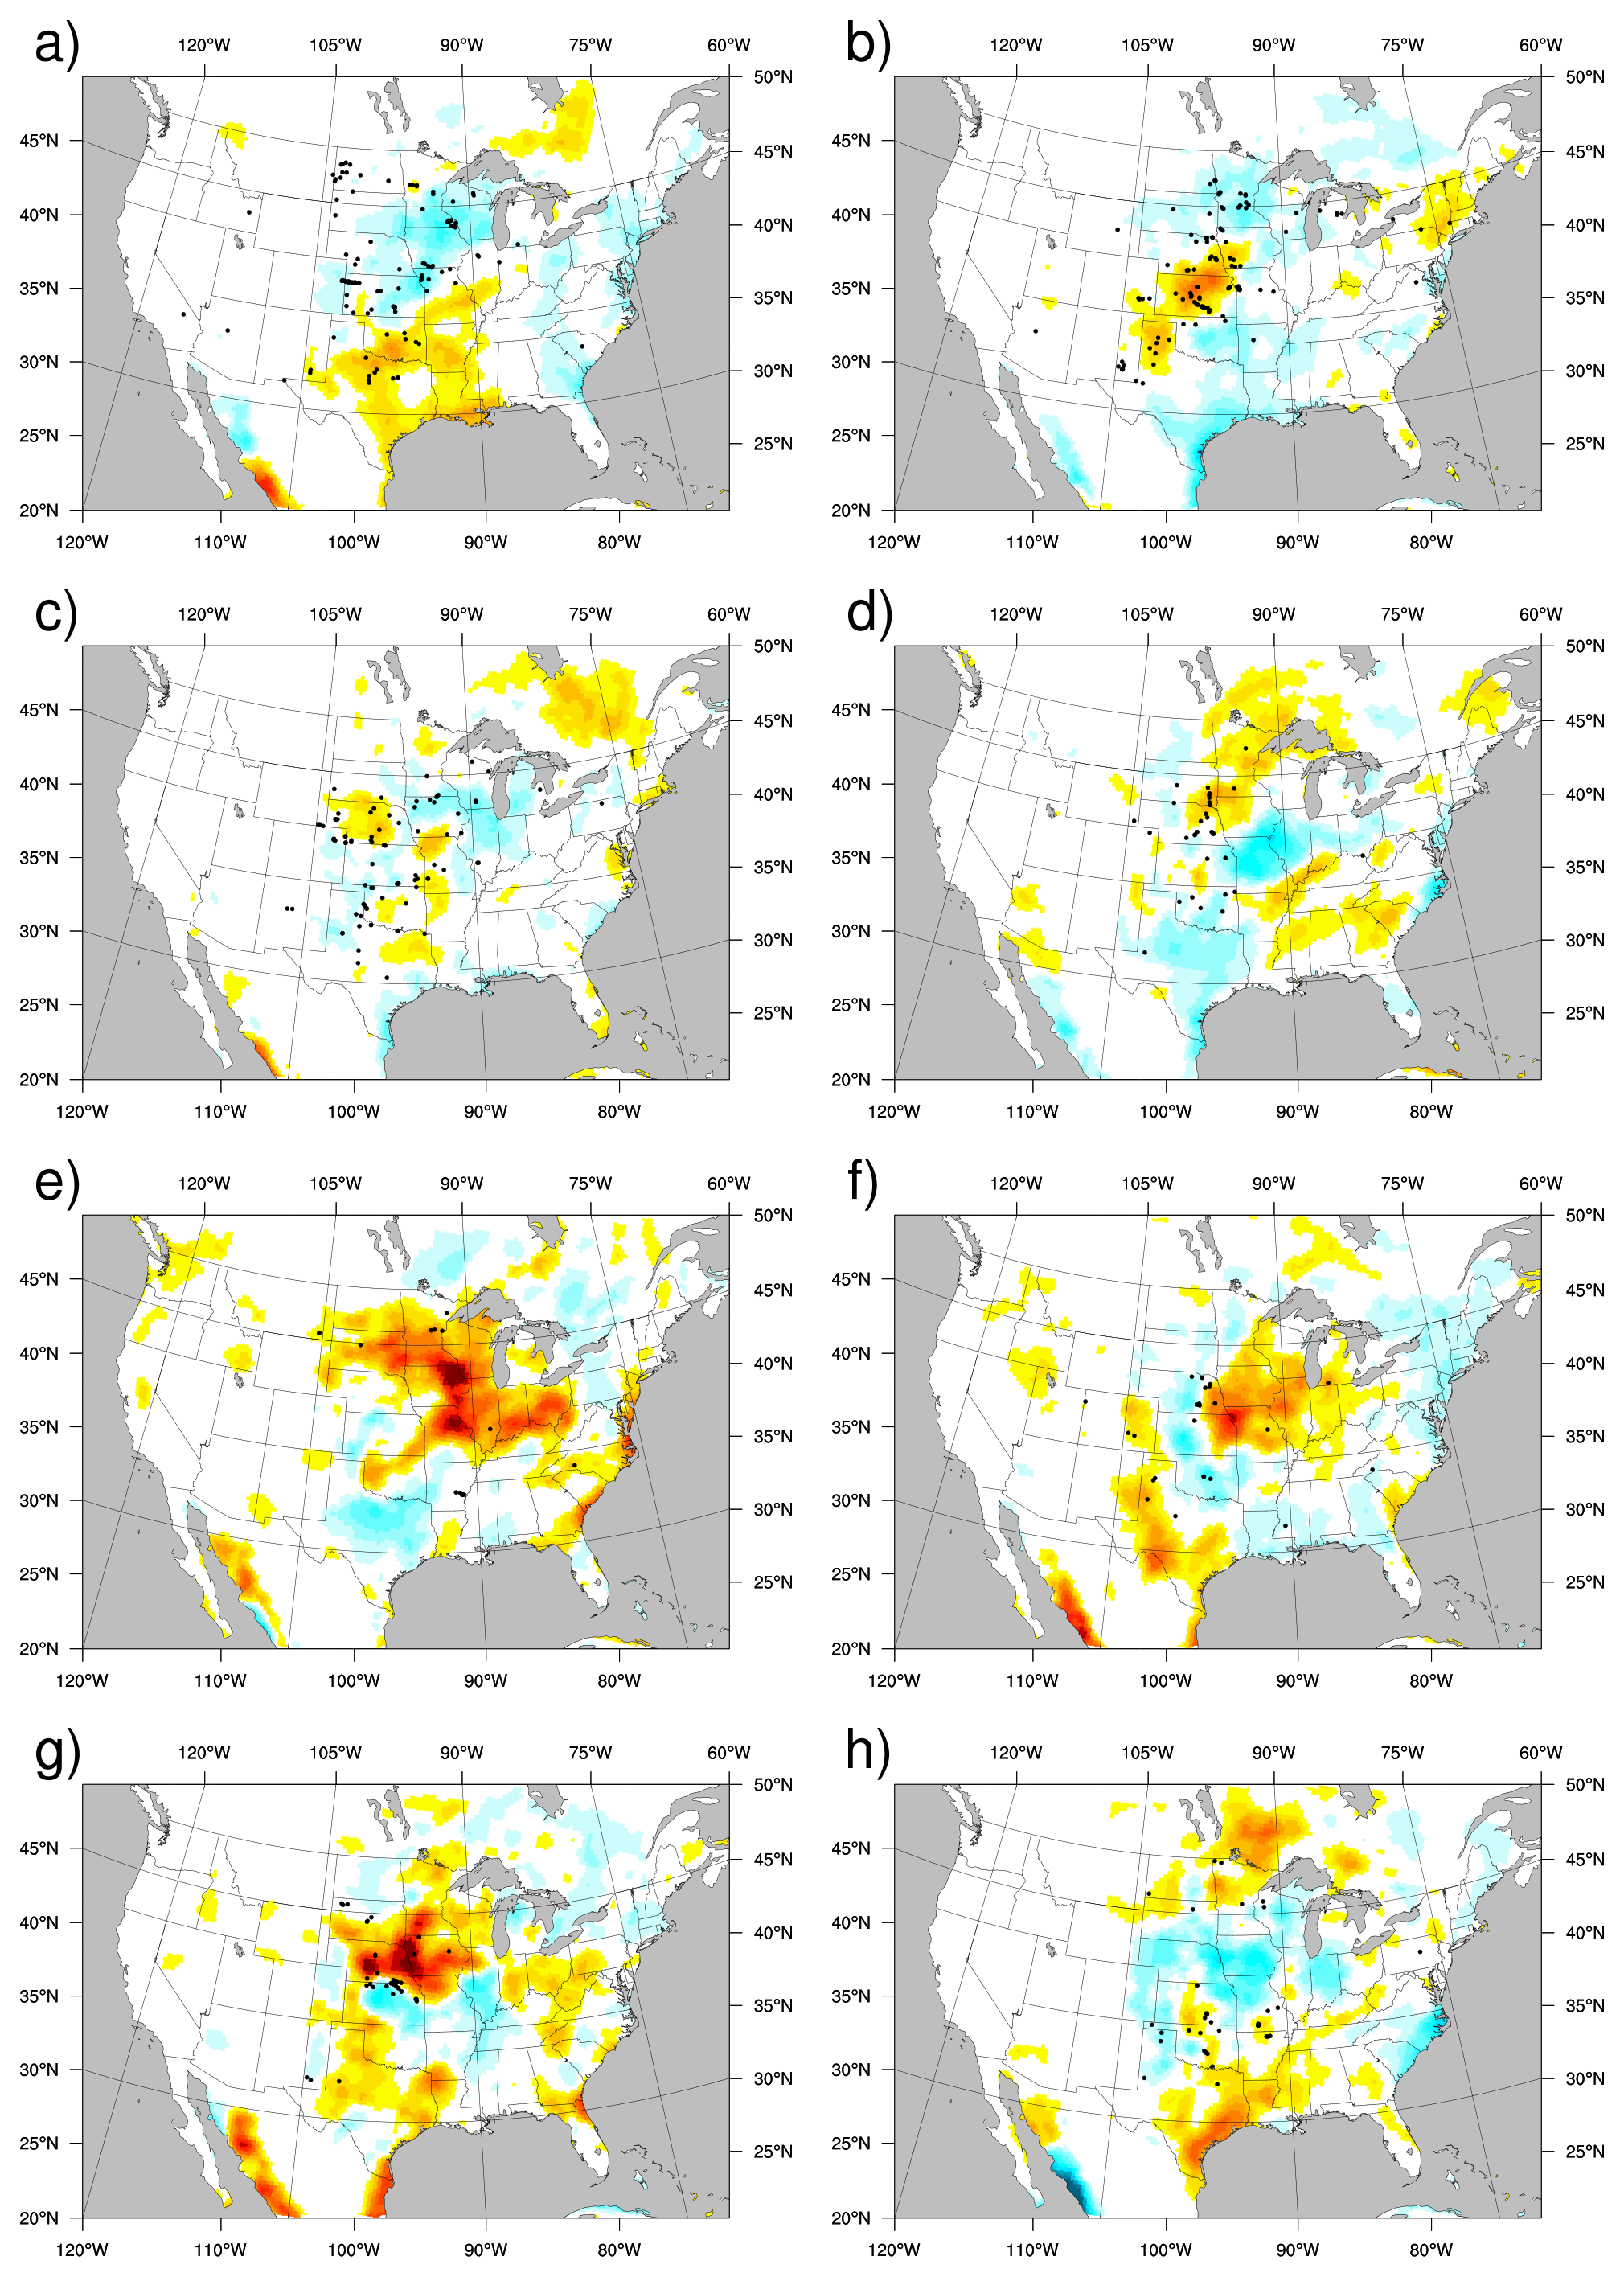

In [5]:
montage='montage -background white -tile 2x4 -geometry +25+25 -trim %s_1.png %s_2.png %s_3.png %s_4.png %s_5.png %s_6.png %s_7.png %s_8.png panel_%s.png' % (str(months[0]),str(months[0]),str(months[0]),str(months[0]),str(months[0]),str(months[0]),str(months[0]),str(months[0]),str(months[0]))  
os.system(montage)
Image('panel_%s.png' % (str(months[0])))